In [8]:
CUDA_INDEX = 0
NAME = 'GED_IMDBMulti'

In [9]:
import sys
sys.path.insert(0, '../..')
sys.path.insert(0, '../../pyged/lib')

In [10]:
import os
import pickle
import random
import time

import IPython as ipy
import matplotlib.pyplot as plt
import numpy as np
import torch
torch.cuda.set_device(CUDA_INDEX)
torch.backends.cudnn.benchmark = True
import torch.optim
import torch_geometric as tg
import torch_geometric.data
from tqdm.auto import tqdm

from neuro import config, datasets, metrics, models, train, utils, viz
import pyged

from importlib import reload
reload(config)
reload(datasets)
reload(metrics)
reload(models)
reload(pyged)
reload(train)
reload(utils)
reload(viz)

<module 'neuro.viz' from '../../neuro/viz.py'>

In [12]:
preds = [
#     ('GENN          ', torch.load(f'../preds/{NAME}/GENN_pred.pt', map_location='cpu').view(-1)),
    ('NeuroSED_G      ', torch.load(f'../preds/{NAME}/inner_pred.pt', map_location='cpu')),
    ('H2MN-RW       ', torch.as_tensor(np.load(f'../preds/{NAME}/h2mn_rw.npy')).T.flatten()),
    ('H2MN-NE       ', torch.as_tensor(np.load(f'../preds/{NAME}/h2mn_ne.npy')).T.flatten()),
#     ('NeuroGSim-Norm', torch.load(f'../preds/{NAME}/norm_inner_pred.pt', map_location='cpu')),
#     ('NeuroGSim-NN  ', torch.load(f'../preds/{NAME}/nn_inner_pred.pt', map_location='cpu')),
#     ('NeuroGSim-Dual', torch.load(f'../preds/{NAME}/dual_inner_pred.pt', map_location='cpu')),
    ('SimGNN        ', torch.as_tensor(np.load(f'../preds/{NAME}/sg_inner_pred.npy'))),
    ('Branch        ', torch.load(f'../preds/{NAME}/b_inner_pred.pt', map_location='cpu')),
    ('F2            ', torch.load(f'../preds/{NAME}/f2_inner_pred.pt', map_location='cpu')),
]

In [13]:
inner_test_set, _ = torch.load(f'/data/rishabh/neurosim/final/data/{NAME}/inner_test.pt', map_location='cpu')
queries, targets, lb, ub = inner_test_set

In [6]:
new_queries = []
new_targets = []
for i in range(140):
    new_queries += queries[i*560:i*560+420]
    new_targets += targets[i*560:i*560+420]
queries = new_queries
targets = new_targets
lb = lb.view(140,560)[:,:420].reshape(-1)
ub = ub.view(140,560)[:,:420].reshape(-1)

RuntimeError: shape '[140, 560]' is invalid for input of size 360000

In [14]:
ged = (lb+ub)/2
gs = torch.tensor([x.num_nodes for x in queries])
hs = torch.tensor([x.num_nodes for x in targets])
slb = utils.similarity_of_ged(ged, gs, hs)
sub = utils.similarity_of_ged(ged, gs, hs)

In [9]:
ged[:100]

tensor([ 27.,  42.,   0.,  33.,  31.,  67., 131.,   0.,   0., 176., 187.,  50.,
        182.,   8.,   0.,  92.,   8.,  14., 119.,   8.,   8.,   9.,  51., 105.,
        102.,  62.,   8.,  44.,  52.,  27.,  25., 236.,   8.,   8.,  17., 127.,
         44.,   0.,  27.,   0., 225.,  49.,   8.,  16., 226.,   0., 182.,  23.,
          0., 161.,  57., 225.,  66.,  20.,  17.,  17., 236., 713., 182., 125.,
         30.,   8.,   8.,   8.,  17.,  14.,  13.,  55., 240.,   8.,  42.,  35.,
         55.,  32., 713.,  17.,   0.,   9.,   0.,   9.,  19.,  80.,  26.,   0.,
         66.,  17.,   8.,  51., 734.,   8.,   9.,   0.,   8.,   0., 145.,  69.,
         17.,   0.,  29.,  12.])

In [7]:
slb[:10]

tensor([6.7206e-02, 3.0197e-02, 1.0000e+00, 3.6883e-02, 5.9714e-02, 9.8460e-03,
        1.2090e-03, 1.0000e+00, 1.0000e+00, 2.7851e-04], device='cuda:3')

In [8]:
sub[:10]

tensor([6.7206e-02, 3.0197e-02, 1.0000e+00, 3.6883e-02, 5.9714e-02, 9.8460e-03,
        1.2090e-03, 1.0000e+00, 1.0000e+00, 2.7851e-04], device='cuda:3')

In [52]:
spred[:10]

tensor([0.3169, 0.1759, 0.2827, 0.4166, 0.3028, 0.2284, 0.1080, 0.2677, 0.1770,
        0.2161], device='cuda:3', dtype=torch.float64)

In [10]:
print('=== RMSE / MSE / MAE / R2 ===')
print()
for label, pred in preds:
#     print(f'{label}', end='\n')
    print(f'{metrics.rmse(lb, ub, pred):.3f}', end=' / ')
#     print(f'{metrics.mse(lb, ub, pred):.3f}', end=' / ')
    print(f'{metrics.mae(lb, ub, pred):.3f}', end=' / ')
    print(f'{metrics.r2(lb, ub, pred)*100:.2f}')
#     print()

=== RMSE / MSE / MAE / R2 ===

6.734 / 3.612 / 99.80
86.077 / 28.486 / 66.85
87.593 / 28.182 / 65.68
66.250 / 28.082 / 80.36
6.875 / 3.303 / 99.79
81.638 / 35.325 / 70.18


In [11]:
print('=== sim RMSE / MSE / MAE / R2 ===')
print()
for label, pred in preds:
#     print(f'{label}', end='\n')
    spred = utils.similarity_of_ged(pred, gs, hs)
    print(f'{metrics.rmse(slb, sub, spred):.3f}', end=' / ')
#     print(f'{metrics.mse(slb, sub, spred):.3f}', end=' / ')
    print(f'{metrics.mae(slb, sub, spred):.3f}', end=' / ')
    print(f'{metrics.r2(slb, sub, spred)*100:.2f}')
#     print()

=== sim RMSE / MSE / MAE / R2 ===

0.035 / 0.018 / 97.95
0.027 / 0.010 / 98.77
0.025 / 0.010 / 98.97
0.075 / 0.038 / 90.74
0.038 / 0.012 / 97.62
0.113 / 0.068 / 79.07


In [12]:
print('=== MSE (10^-3) as in SimGNN')
print()
for label, pred in preds:
    spred = utils.similarity_of_ged(pred, gs, hs)
    print(f'{metrics.rmse(slb, sub, spred)**2*1000:.3f}')

=== MSE (10^-3) as in SimGNN

1.243
0.744
0.624
5.618
1.441
12.701


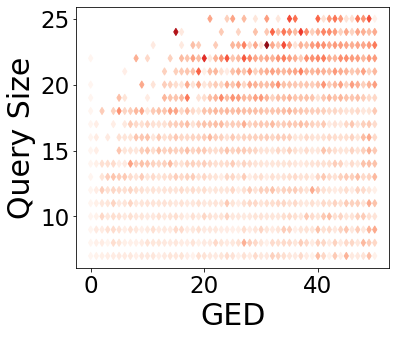

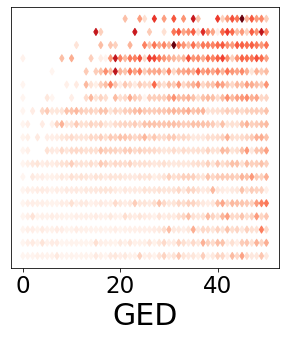

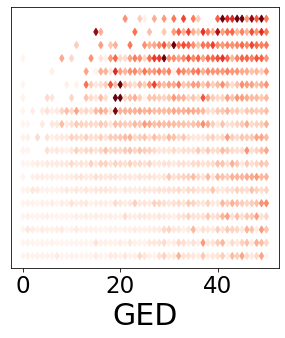

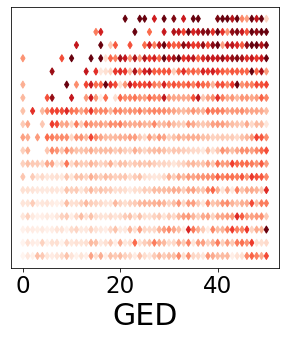

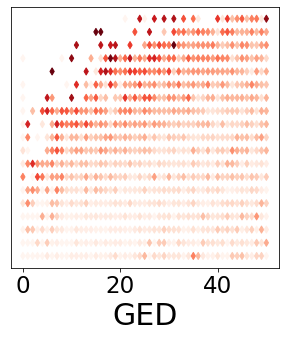

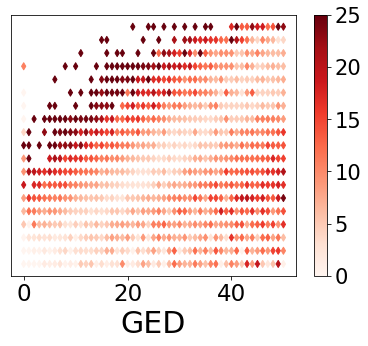

In [16]:
for i, (label, pred) in enumerate(preds):
    if i == 0:
        plt.figure(figsize=(5.6,4.8))
    elif i == len(preds)-1:
        plt.figure(figsize=(6.4,4.8))
    else:
        plt.figure(figsize=(4.8,4.8))
    err = metrics.err(lb, ub, pred)
    gsz = torch.tensor([g.num_nodes for g in queries])
    viz.plot_corr_2d(ged, gsz, err, xmax1=50, xmax2=25, bin_size1=1, bin_size2=1, s=25, cmap='Reds', vmax=25, vmin=0, marker='d')
    if i == len(preds)-1:
        cbar = plt.colorbar()
        cbar.ax.tick_params(labelsize=21)
    plt.xlabel('GED', fontsize=30)
    if i == 0:
        plt.ylabel('Query Size', fontsize=30)
    else:
        plt.yticks([])
    plt.tick_params(axis='both', which='major', labelsize=23)
    plt.savefig(f'../plots/Heatmap.{NAME}.{i}_{label.strip()}.eps', bbox_inches='tight')
    plt.show()
    plt.close()